In [224]:
import dgl
import torch as th
import sys
import os
sys.path.append('./..')
import pandas as pd
import numpy as np
from pandarallel import pandarallel
pandarallel.initialize()
from dgl.data.utils import save_graphs
import pickle
from dgl.data.utils import load_graphs
from torch import nn
from torch.nn import functional as F
from torch import FloatTensor as FT
from torch import LongTensor as LT
import torch
import dgl.function as fn
from torch import FloatTensor as FT
from torch import LongTensor as LT
from tqdm import tqdm

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
def read_DBLP_data():
    
    loc = './../DBLP'
    fname_e = 'dblp_edges.csv'
    fname_n = 'dblp_nodes.csv'
    df_e = pd.read_csv(os.path.join(loc,fname_e),low_memory=False)
    df_n = pd.read_csv(os.path.join(loc,fname_n),low_memory=False)
    
    # ----------------------------------------
    # replace the node id by synthetic id 
    # ----------------------------------------
    def replace_id(val):      
        num = val[1:]
        t = val[0]
        return df_n.loc[
            (df_n['type']==t) & (df_n['ID']==val)
        ]['synID'].values.tolist()
        
    df_e['n1'] = df_e['n1'].parallel_apply(replace_id)
    df_e['n2'] = df_e['n2'].parallel_apply(replace_id)
    
    graph_data = {}
    print('Types of edges', set(df_e['etype']))
    
    for et in set(df_e['etype']):
        et_R = et[::-1]
        tmp = df_e.loc[df_e['etype']==et]
        n1 = tmp['n1'].values.tolist()
        n2 = tmp['n2'].values.tolist()
        _list = []
        _list_R = []
        for i,j in zip(n1,n2):
            _list.append((i[0], j[0]))
            _list_R.append((j[0], i[0]))
        graph_data [(et[0], et, et[1])] = _list 
        graph_data [(et[1], et_R, et[0])] = _list_R  
    return graph_data

In [4]:
graph_data = read_DBLP_data()
g = dgl.heterograph(graph_data)
print('Node types, edge types', g.ntypes, g.etypes)
print('Graph ::', g)

Types of edges {'PA', 'PT', 'PC'}
Node types, edge types ['A', 'C', 'P', 'T'] ['AP', 'CP', 'PA', 'PC', 'PT', 'TP']
Graph :: Graph(num_nodes={'A': 4057, 'C': 20, 'P': 14328, 'T': 3590},
      num_edges={('A', 'AP', 'P'): 19645, ('C', 'CP', 'P'): 14328, ('P', 'PA', 'A'): 19645, ('P', 'PC', 'C'): 14328, ('P', 'PT', 'T'): 81823, ('T', 'TP', 'P'): 81823},
      metagraph=[('A', 'P', 'AP'), ('P', 'A', 'PA'), ('P', 'C', 'PC'), ('P', 'T', 'PT'), ('C', 'P', 'CP'), ('T', 'P', 'TP')])


In [5]:
SAVE_FILE = "./dblp_graph_obj.dgl"

In [5]:
save_graphs(SAVE_FILE, g)

In [6]:
g,_ = load_graphs(SAVE_FILE)

In [7]:
graph_obj = g[0]

In [8]:
print('Node types, edge types', graph_obj.ntypes, graph_obj.etypes)
print('Graph ::', graph_obj)

Node types, edge types ['A', 'C', 'P', 'T'] ['AP', 'CP', 'PA', 'PC', 'PT', 'TP']
Graph :: Graph(num_nodes={'A': 4057, 'C': 20, 'P': 14328, 'T': 3590},
      num_edges={('A', 'AP', 'P'): 19645, ('C', 'CP', 'P'): 14328, ('P', 'PA', 'A'): 19645, ('P', 'PC', 'C'): 14328, ('P', 'PT', 'T'): 81823, ('T', 'TP', 'P'): 81823},
      metagraph=[('A', 'P', 'AP'), ('P', 'A', 'PA'), ('P', 'C', 'PC'), ('P', 'T', 'PT'), ('C', 'P', 'CP'), ('T', 'P', 'TP')])


In [10]:
metapaths = {
    'C' : ['CP', 'PC' ],
    'T' : ['TP', 'PT' ],
    'P' : ['PT', 'TP', 'PC' , 'CP']
}



In [9]:
def get_RW_list(graph_obj, metapaths, prefix=True):
    def add_prefix(prefix, val):
        return prefix + str(val)
    
    node_typeID2typename = {}
    for e in  enumerate(graph_obj.ntypes): 
        node_typeID2typename[e[0]]= e[1]
    
    RW_list =[]
    for ntype, mp in metapaths.items():
        mp =  mp * 10
        RW_mp = dgl.sampling.random_walk(
            graph_obj,
            metapath= mp,
            nodes = graph_obj.nodes(ntype),
        )
        print(RW_mp[1])
        _random_walks = RW_mp[0].data.numpy()
        if prefix:
            pattern = RW_mp[1].data.numpy().tolist()
            pattern = [node_typeID2typename[_] for _ in pattern ]
            print(pattern)
            vectorized_func = np.vectorize(add_prefix)
            _random_walks = vectorized_func( patterlengthn, _random_walks)
           
        RW_list.extend(_random_walks.tolist())
        
    return RW_list

In [72]:
random_walks = get_RW_list(graph_obj, metapaths)

tensor([1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1])
['C', 'P', 'C', 'P', 'C', 'P', 'C', 'P', 'C', 'P', 'C', 'P', 'C', 'P', 'C', 'P', 'C', 'P', 'C', 'P', 'C']
tensor([3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3])
['T', 'P', 'T', 'P', 'T', 'P', 'T', 'P', 'T', 'P', 'T', 'P', 'T', 'P', 'T', 'P', 'T', 'P', 'T', 'P', 'T']
tensor([2, 3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 1,
        2, 3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2])
['P', 'T', 'P', 'C', 'P', 'T', 'P', 'C', 'P', 'T', 'P', 'C', 'P', 'T', 'P', 'C', 'P', 'T', 'P', 'C', 'P', 'T', 'P', 'C', 'P', 'T', 'P', 'C', 'P', 'T', 'P', 'C', 'P', 'T', 'P', 'C', 'P', 'T', 'P', 'C', 'P']


True

In [10]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import multiprocessing as mp

cpu_count = mp.cpu_count()

In [14]:
class loss_callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0
            
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1


In [15]:
def node2vec(random_walks, epochs = 100):
    cpu_count = mp.cpu_count()
    model = Word2Vec(
        random_walks, 
        size=128, 
        window=3, 
        negative = 10,
        sg = 1,
        min_count=1, 
        iter = epochs,
        compute_loss=True,
        callbacks= [loss_callback()]
    )
  
    return model

In [16]:
model = node2vec(random_walks)

Loss after epoch 0: 2959041.25
Loss after epoch 1: 1616846.75
Loss after epoch 2: 1539773.5
Loss after epoch 3: 1494218.5
Loss after epoch 4: 1329412.0
Loss after epoch 5: 1068293.0
Loss after epoch 6: 1019163.0
Loss after epoch 7: 1126825.0
Loss after epoch 8: 1063675.0
Loss after epoch 9: 925662.0
Loss after epoch 10: 1026505.0
Loss after epoch 11: 965177.0
Loss after epoch 12: 907416.0
Loss after epoch 13: 795062.0
Loss after epoch 14: 781654.0
Loss after epoch 15: 731722.0
Loss after epoch 16: 750374.0
Loss after epoch 17: 710116.0
Loss after epoch 18: 652882.0
Loss after epoch 19: 711134.0
Loss after epoch 20: 694964.0
Loss after epoch 21: 627070.0
Loss after epoch 22: 689686.0
Loss after epoch 23: 614478.0
Loss after epoch 24: 646726.0
Loss after epoch 25: 669510.0
Loss after epoch 26: 611840.0
Loss after epoch 27: 662960.0
Loss after epoch 28: 653640.0
Loss after epoch 29: 650250.0
Loss after epoch 30: 567358.0
Loss after epoch 31: 658266.0
Loss after epoch 32: 578638.0
Loss aft

In [17]:
model.save("node2vec.model")

In [75]:
def get_node_vectors(w2v_model):
    vectors_dict = {} 
    for node, vec  in  w2v_model.wv.vocab.items():
        _type = node[0]
        _id = int(node[1:])
        if _id < 0 : continue
     
        if _type not in vectors_dict.keys(): vectors_dict[_type]= {}
        vectors_dict[_type][_id] = w2v_model.wv[node]
    return vectors_dict 

In [78]:
vectors_dict =  get_node_vectors(model)

In [79]:
len(vectors_dict['C'])

20

In [80]:
# Save the node2vec vectors
with open("node2vec_vectors_dblp.pkl",'wb') as fh:
    pickle.dump(vectors_dict, fh, pickle.HIGHEST_PROTOCOL)

In [11]:
with open("node2vec_vectors_dblp.pkl",'rb') as fh:
    vectors_dict = pickle.load(fh)

In [16]:
# ---------------------------------
# Assign the vectors to nodes 
# ---------------------------------
for _type,vec_dict in vectors_dict.items():
    # Sort by keys
    vec_dict = {k: vec_dict[k] for k in sorted(vec_dict)}
    arr = np.array(list(vec_dict.values()))
    print(arr.shape)
    graph_obj.nodes[_type].data['mp2v'] = FT(arr)


(20, 128)
(14328, 128)
(3590, 128)


In [138]:
graph_obj.nodes['A'][0]['features'][(10,12),:].shape

torch.Size([2, 128])

In [139]:
graph_obj.nodes['A']

NodeSpace(data={'h': tensor([[-2.3155,  0.9874, -1.0372,  ..., -3.5197,  1.6381, -0.4157],
        [ 0.1247,  0.7769, -0.2920,  ..., -0.4021,  0.0756, -0.2785],
        [-0.2103,  0.9218,  0.1488,  ..., -0.1678,  1.2385,  0.2185],
        ...,
        [ 0.9587,  0.1735,  0.3462,  ..., -2.0214, -1.3904,  1.0250],
        [-0.3391,  0.4953,  0.4317,  ..., -0.3763,  0.1117, -0.4074],
        [-0.1395,  1.5959, -0.8736,  ...,  0.3145, -0.3659, -0.0525]]), 'features': tensor([[-1.7605e-03,  1.1173e-03,  9.0707e-05,  ..., -1.7978e-03,
          1.7927e-03, -1.4459e-03],
        [ 1.3830e-04, -2.7170e-04, -1.6747e-03,  ..., -1.5016e-03,
          1.6060e-03,  1.4256e-03],
        [ 1.3713e-04,  1.2106e-03,  4.5244e-04,  ..., -1.1915e-03,
          2.0488e-04,  3.6495e-04],
        ...,
        [-1.5831e-03, -6.6044e-04, -1.7741e-03,  ..., -1.6603e-03,
         -1.5522e-03, -1.3597e-03],
        [ 1.5274e-03,  1.4183e-03, -1.7338e-03,  ...,  8.5928e-04,
          1.5271e-03,  8.4462e-04],
    

In [ ]:
graph_obj.nodes['A'][0]['h'][(10,12),:].shape

In [232]:
class GNN_1(nn.Module):
    def __init__(
        self,
        inp_dim,
        out_dim,
        edge_type,
        target_type,
        aggregator_type='mean',
        bias=True,
        norm=True,
        activation=None
    ):
        super(GNN_1, self).__init__()
        self.out_dim = out_dim
        self.inp_dim = inp_dim
        self.aggregator_type = aggregator_type
        self.norm = norm
        self.activation = activation
        
        # ------
        # Assuming a 2 layer GNN
        # ------
        self.num_layers = 2 
        self.FC_w = nn.Linear(self.inp_dim*2, self.out_dim, bias=bias)
        self.reset_parameters()
        self.aggregator_type = aggregator_type
        self.edge_type = edge_type
        self.tgt_node_type = target_type 
        return
    
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_uniform_(self.FC_w.weight, gain=gain)
        return
    
    
    def forward(self, graph):        
        for layer in range( self.num_layers ):
            funcs = {}
            funcs[self.edge_type] = (
                fn.copy_u('mp2v', 'm'), 
                fn.sum('m', 'h')
            )
            # Update along the given edge
            graph_obj.multi_update_all(funcs, 'sum')
            
            # --------------------------------------
            # If first layer store the result from h
            # --------------------------------------
            if layer == 0 :
                graph_obj.nodes[self.tgt_node_type].data['features'] = graph_obj.nodes[self.tgt_node_type].data['h']
            else:
                concat_ftrs = torch.cat([
                    graph_obj.nodes[self.tgt_node_type].data['features'],
                    graph_obj.nodes[self.tgt_node_type].data['h']
                ], dim=1)
                
                ftrs = self.FC_w(concat_ftrs)
                ftrs = F.tanh(ftrs)
                if self.norm:
                    ftrs = ftrs/torch.norm(ftrs,p=2)
                graph_obj.nodes[self.tgt_node_type].data['features'] = ftrs 
        return

In [88]:
def generate_negative_edges(graph_obj, edge_type):
    src_type = None
    dst_type = None
    for ce in graph_obj.canonical_etypes:
        if ce[1]==edge_type:
            src_type = ce[0] 
            dst_type = ce[2]
    src_nodes = graph_obj.nodes(src_type).data.numpy()
    dst_nodes = graph_obj.nodes(dst_type).data.numpy()
    valid_edges = graph_obj.edges(etype=edge_type)
    
    # --------------------------------- #
    def join(a, b):
        return str(a) + '_' + str(b)

    def add_prefix(a,p):
        return p + str(a)
    
    def remove_prefix(a):
        return int(a[1:])
    
    vectorized_join = np.vectorize(myfunc)
    vectorized_prefix = np.vectorize(add_prefix)
    vectorized_rmv_prefix = np.vectorize(remove_prefix)
    
    # --------------------------------- #
    node_pairs = []
    for v,prefix in zip(valid_edges,(src_type,dst_type)):
        n = vectorized_prefix(v,prefix)
        node_pairs.append(n)
    
    src_nodes = vectorized_prefix(src_nodes,prefix)
    dst_nodes = vectorized_prefix(dst_nodes,prefix)
    
    set_src_nodes = set(node_pairs[0])
    set_dst_nodes = set(node_pairs[1])
    
    pos_nbrs = { _: [] for _ in set_src_nodes }
    neg_nbrs = { _ :[] for _ in set_src_nodes }
    
    for i,j  in zip(node_pairs[0],node_pairs[1]):
        pos_nbrs[i].append(j)
    
    # Final list to be sent
    neg_nbr_dict = {}
    pos_nbr_dict = {}
    
    for i in set_src_nodes:
        pos_nbrs[i] = set(pos_nbrs[i])
        neg_nbrs[i] = list(set_dst_nodes.difference(pos_nbrs[i]))
        neg_nbrs[i] = vectorized_rmv_prefix(neg_nbrs[i])
        pos_nbrs[i] = vectorized_rmv_prefix(list(pos_nbrs[i]))
        _key = int(i[1:])
        
        neg_nbr_dict[_key] = neg_nbrs[i] 
        pos_nbr_dict[_key] = pos_nbrs[i] 
    
    
    # For each source type get negative destination neighbors
    
    return pos_nbr_dict,neg_nbr_dict

In [90]:
pos_nbr_dict,neg_nbr_dict = generate_negative_edges(graph_obj, edge_type='AP')

In [236]:
# get ptriplets [ anchor ,ositive and negative ]
def get_triplets(pos_nbr_dict, neg_nbr_dict):
   
    nodes = list(pos_nbr_dict.keys())
    pos_pairs = []
    neg_pairs = []
    triplets = []
    for n in nodes:
        t =[n, 
            np.random.choice(pos_nbr_dict[n],size=1)[0], 
            np.random.choice(neg_nbr_dict[n],size=1)[0]
        ]
        triplets.append(t)
    triplets = np.array(triplets)
    
#     print(triplets.shape)
    return triplets

In [211]:
# loss = torch.mean(torch.max(distance, torch.zeros_like(distance))) 

In [152]:
# triplets = get_triplets(pos_nbr_dict,neg_nbr_dict, count=10)

In [212]:
# def calc_margin_loss(x1,x2, m, pos=True):
#     d = 1 - F.cosine_similarity(0)    
#     if not pos:
#         d = torch.floor(0, m - d)
#     return d 


In [213]:
# t = get_triplets(pos_nbr_dict,neg_nbr_dict)


In [341]:
def calc_loss( xt, xp, xn):
    m = 0.25
    v1 = 1 - F.cosine_similarity(xt, xp, dim=1)
    v2 = 1 - F.cosine_similarity(xt, xn, dim=1)
    
    d =  v1 - v2 + m
    loss = torch.max(d, torch.zeros_like(d))

    return torch.mean(loss, dim=0, keepdim=False)

In [342]:
def train_model(
    graph_obj, 
    gnn_obj,
    pos_nbr_dict,
    neg_nbr_dict,
    tgt_edge = 'AP',
    tgt_node = 'A',
    cmp_node = 'P',
    num_epochs = 10
):
    opt = torch.optim.Adam(
        list(gnn_obj.parameters())
    )
    
#     pos_nbr_dict,neg_nbr_dict = generate_negative_edges(graph_obj, edge_type = tgt_edge)
    pbar = tqdm(range(num_epochs))
    for e in pbar :
        opt.zero_grad()
        triplets = get_triplets(pos_nbr_dict,neg_nbr_dict)
       
        gnn_obj(graph_obj)
        idx_t = LT(triplets[:,0])
        emb_t = graph_obj.nodes[tgt_node][0]['features'][idx_t,:] 
       
        idx_p = LT(triplets[:,1])
        idx_n = LT(triplets[:,2])
        emb_p = graph_obj.nodes[cmp_node][0]['mp2v'][idx_p,:] 
        emb_n = graph_obj.nodes[cmp_node][0]['mp2v'][idx_n,:] 
        loss_val = calc_loss(emb_t, emb_p, emb_n)
        loss_val.backward()
        opt.step()
#         print(' Epoch {} Loss {:4f}'.format(e,np.mean(loss_val.data.numpy())))
        pbar.set_postfix({'Loss': '{:4f}'.format(np.mean(loss_val.data.numpy()))})

    return
              
        

In [ ]:
tgt_edge = 'AP'
pos_nbr_dict,neg_nbr_dict = generate_negative_edges(graph_obj, edge_type = tgt_edge)

In [343]:
gnn_obj = GNN_1(
        inp_dim=128,
        out_dim=128,
        edge_type='PA',
        target_type='A',
        aggregator_type='mean',
        bias=True,
        norm=True,
        activation='tanh'
)

In [344]:
train_model(
    graph_obj, 
    gnn_obj,
    pos_nbr_dict,
    neg_nbr_dict,
    num_epochs = 400
)

  0%|          | 0/400 [00:00<?, ?it/s]/home/ddatta/anaconda3/envs/SG/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 400/400 [03:34<00:00,  1.87it/s, Loss=0.016761]


In [345]:
A_features = graph_obj.nodes['A'][0]['features'].data.numpy()

In [346]:
A_features

array([[-2.0211672e-03,  8.1119360e-04, -8.3204848e-04, ...,
        -2.1621876e-03,  1.8022689e-03, -4.5910574e-04],
       [ 7.4668345e-04,  2.3519321e-04, -7.6314237e-04, ...,
         9.1296551e-04, -6.4705824e-04, -7.0769893e-04],
       [ 1.1626004e-04, -2.8986629e-04, -4.6374782e-05, ...,
         1.7234766e-03,  8.9080253e-04,  5.6282204e-04],
       ...,
       [ 1.9880640e-03, -1.8586463e-03,  1.3739058e-03, ...,
        -1.7143299e-03, -1.7751486e-03,  1.6799540e-03],
       [-4.7051569e-04,  5.4853157e-05,  9.9812273e-04, ...,
         1.3101585e-03, -8.7983487e-04, -9.2044682e-04],
       [ 1.9209052e-03, -1.5821884e-03, -1.6924156e-03, ...,
         2.1613550e-03, -6.9595687e-04, -7.4295484e-04]], dtype=float32)

In [332]:
from sklearn import metrics
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [347]:
reduced_data = PCA(n_components=2).fit_transform(A_features)

In [348]:
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10, n_jobs=-1)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [349]:
from matplotlib import pyplot as plt

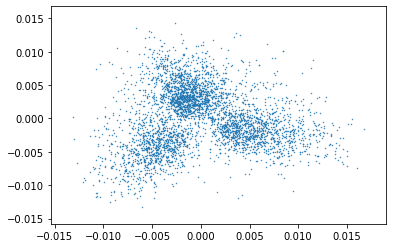

In [350]:
plt.scatter(
    reduced_data[:,0], reduced_data[:,1],s=0.2
)

In [351]:
# read in labels 
df_nodes = pd.read_csv('./../DBLP/dblp_nodes.csv',index_col=None)
labels_list = df_nodes.loc[df_nodes['type']=='A']['label'].astype(int).values

In [352]:
labels = labels_list
x = reduced_data[:,0]
y = reduced_data[:,1]
data = np.vstack([x,y,labels])

In [353]:
data = data.transpose()
data.shape

(4057, 3)

In [354]:
df = pd.DataFrame(data, columns=['x','y','label'])

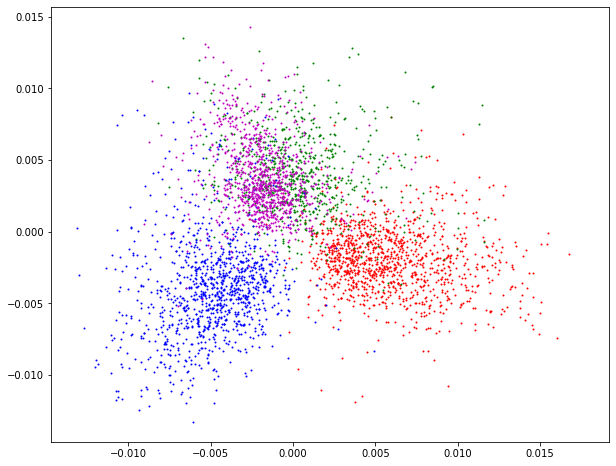

In [356]:
plt.figure(figsize=[10,8])
colors = ['r','g','b','m']
for l in range(4):
    _x = df.loc[df['label']==l]['x'].values
    _y = df.loc[df['label']==l]['y'].values
    c = colors[l]
    plt.scatter(_x,_y,color=c,s=0.975)
plt.show()
    